In [1]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from DataProcessor import DataProcessor
import numpy as np
import math
from Chromosome import *
from Recombination import Recombination
import random
from NSGAII import NSGAII
import matplotlib.pyplot as plt
from pymoo.indicators.hv import Hypervolume
from pymoo.indicators.igd import IGD
import time
import pandas as pd
from datetime import datetime

In [2]:
def plot_pareto_front(data):
    x_values = [item.objectives[1] for item in data]
    y_values = [item.objectives[0] for item in data]
    plt.scatter(x_values, y_values, marker='o', color='b')
    plt.xlabel('Solution Size')
    plt.ylabel('Classification Error')
    plt.title('Final Pareto Front')
    plt.show()

In [3]:
def fast_non_dominated_sort( population):
        fronts = [[]]
        for p in population:
            p.domination_count = 0
            p.dominated_solutions = set()

            for q in population:
                if p.dominate(q):
                    p.dominated_solutions.add(q)
                elif q.dominate(p):
                    p.domination_count += 1

            if p.domination_count == 0:
                p.rank = 0
                fronts[0].append(p)

        i = 0
        while fronts[i]:
            next_front = []
            for p in fronts[i]:
                for q in p.dominated_solutions:
                    q.domination_count -= 1
                    if q.domination_count == 0:
                        q.rank = i + 1
                        next_front.append(q)

            i += 1
            fronts.append(next_front)
        return fronts


In [4]:
# for sure values are not correct
def create_chromosome(row, num_features):
    values = np.random.randint(2, size=num_features)
    chromosome = Chromosome(values)
    chromosome.objectives = [row['Classification-error'], row['Solution-size']]
    return chromosome

In [5]:
def calc_true_pareto_front(U_PF_dataset_path, num_features):
    df = pd.read_csv(U_PF_dataset_path)
    population = df.apply(lambda row: create_chromosome(row, num_features), axis=1)
    fronts = fast_non_dominated_sort(population)
    objectives = [chromosome.objectives for chromosome in fronts[0]]
    return objectives

In [6]:
def run_nsga_on_dataset(dataset_name):
    dataset_path = "Datasets/" + dataset_name
    dp = DataProcessor(dataset_path)
    dp.load_data()
    num_objectives = 2
    y = np.array(dp.dataset["LABEL"])
    X = np.array(dp.dataset.drop("LABEL", axis=1, inplace=False))
    num_features = dp.num_features()
    U_PF_dataset_path = "union-pareto/"+ dataset_name
    true_pareto_front = calc_true_pareto_front(U_PF_dataset_path, num_features)    
    print("number of features: ", num_features)
    population_size = 100
    maxFEs = 30000
    Q = 5
    LP = 5
    nsga2 = NSGAII(X, y, population_size, LP, num_features, true_pareto_front, maxFEs)
    current_solutions, igd_values, hypervolume_values = nsga2.nsga2()
    return current_solutions, igd_values, hypervolume_values

In [ ]:
datasets = ["DS02.csv", "DS04.csv", "DS05.csv","DS07.csv", "DS08.csv", "DS10.csv"]
elapsed_times = []
start_times = []
end_times = []

number of features:  56
--------------------


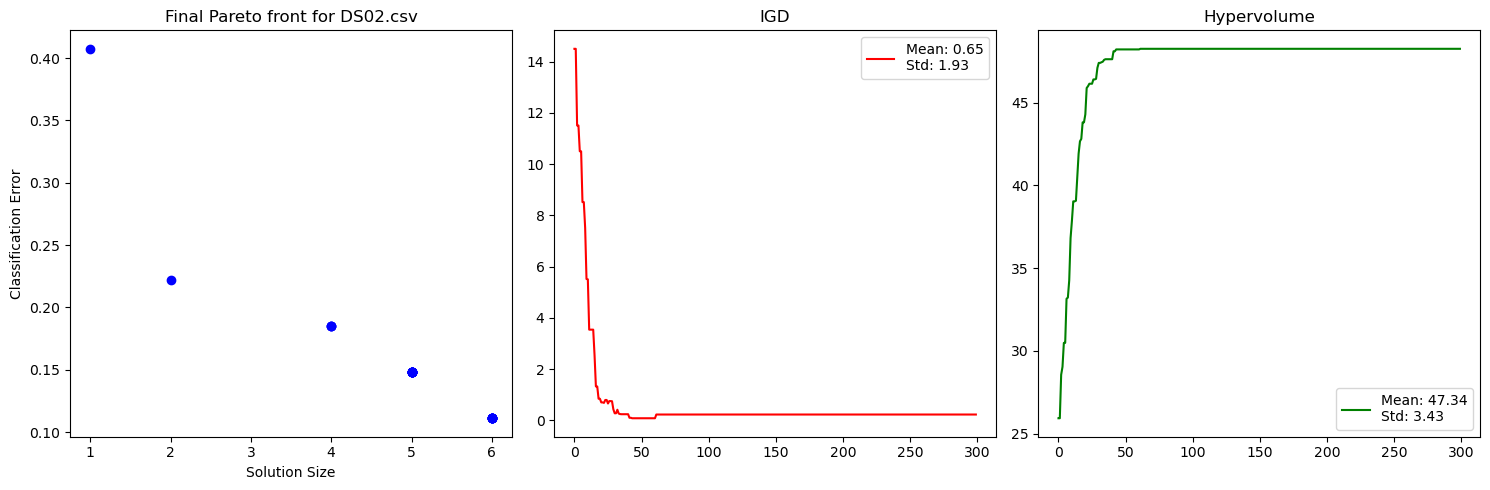

In [7]:
def run_different_dataset(dataset_name):
    start_time = time.time()
    current_solutions, igd_values, hypervolume_values = run_nsga_on_dataset(dataset_name)
    end_time = time.time()
    elapsed_time = end_time - start_time
    duration_minutes = elapsed_time / 60
    elapsed_times.append(duration_minutes)
    start_times.append(datetime.utcfromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S'))
    end_times.append(datetime.utcfromtimestamp(end_time).strftime('%Y-%m-%d %H:%M:%S'))

    print("-"*20)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    x_values = [item.objectives[1] for item in current_solutions]
    y_values = [item.objectives[0] for item in current_solutions]
    plt.scatter(x_values, y_values, marker='o', color='b')
    plt.xlabel('Solution Size')
    plt.ylabel('Classification Error')
    plt.title(f'Final Pareto front for {dataset_name}')

    plt.subplot(1, 3, 2)
    plt.plot(igd_values, color='r', label=f'Mean: {np.mean(igd_values):.2f}\nStd: {np.std(igd_values):.2f}')
    plt.title('IGD')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(hypervolume_values, color='g', label=f'Mean: {np.mean(hypervolume_values):.2f}\nStd: {np.std(hypervolume_values):.2f}')
    plt.title('Hypervolume')
    plt.legend()

    plt.tight_layout()

    plt.show()

In [8]:
from tabulate import tabulate
data = list(zip(["dataset2"], start_times, end_times, elapsed_times))
table = tabulate(data, headers=['Dataset','Start', 'End', 'Duration'], tablefmt='grid')
print(table)

+-----------+---------------------+---------------------+------------+
| Dataset   | Start               | End                 |   Duration |
+===========+=====================+=====================+============+
| dataset2  | 2024-01-04 13:28:21 | 2024-01-04 13:33:20 |     4.9963 |
+-----------+---------------------+---------------------+------------+


In [9]:
4.9

4.9